# qPCR totyrs

In [1]:
import pandas as pd, numpy as np, scipy, re, seaborn as sns, random, pysam, sklearn, glob
sns.set()
import itertools as it

from collections import defaultdict
from scipy import stats, integrate, cluster
from scipy.stats import entropy, spearmanr, ttest_ind, zscore

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles, venn3_unweighted

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Mojito/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Files

In [2]:
qpcr = pd.read_excel('../AT8/qPCR_values.xlsx')
infoc = pd.read_csv('../all_wocnt_all_info.csv', sep=',')
infoc['SampleName']=['{}-{:03d}'.format(_.split('-')[0], int(_.split('-')[1])) if 'SLI' in _ else _ for _ in infoc['SampleName']]
infoc['SampleName'] = [_.replace('-','_') for _ in infoc['SampleName'].tolist()]
infoc = infoc[~infoc['totyrs'].isnull()]
infoc = infoc[infoc['totyrs']<30]
#qpcr = qpcr[~qpcr['AT8 Density - Crest'].isnull()]
qpcr['Case'] = [_.replace('-','_') for _ in qpcr['Case'].tolist()]
print('qPCR samples: ',len(qpcr),'\t RNAseq samples: ',len(infoc))
print('qPCR/RNAseq intersection: ',len(set(qpcr['Case']).intersection(set(infoc['SampleName']))))
print('qPCR/RNAseq difference: ',len(set(qpcr['Case']).difference(set(infoc['SampleName']))))

#inter = pd.merge(qpcr,infoc[list(infoc)[:9]], left_on='Case', right_on='SampleName')
inter_id = list(set(qpcr['Case']).intersection(set(infoc['SampleName'])))
difr_id = list(set(qpcr['Case']).difference(set(infoc['SampleName'])))

qpcr = qpcr.rename(columns={"TNFa": "TNF", "Aqp4": "AQP4", "IL1b":"IL1B","IL-6":"IL6","TGFb1":"TGFB1","IL-10":"IL10",
                            "NRF2":"NFE2L2","C1qA":"C1QA","iNOS":"NOS2","IFNg":"IFNG","IL1a":"IL1A","IL-8":"CXCL8",
                            "HLA-DRA":"HLA_DRA","PSD-95":"DLG4","AT8 Density - Sulcus":"AT8_sulcus",
                            "AT8 Density - Crest":"AT8_crest","Comorbid pathology":"Comorbid"})

# Change AT8 counts to log counts
qpcr['AT8_crest'] = np.log10(qpcr['AT8_crest'])
info_cols = list(qpcr)[:5] + list(qpcr)[-2:]
qpcr_genes = list(qpcr)[5:-2]
qpcr['Status']=['CTEM' if _ == 'Mild CTE' else 'RHIN' if _ == 'RHI without CTE' else 'CTES' for _ in qpcr['pathgroup'].tolist()]

inter = qpcr[qpcr['Case'].isin(inter_id)]

print('qPCR CTES/CTEM/RHIN: ',len(qpcr[qpcr['Status']=='CTES']),len(qpcr[qpcr['Status']=='CTEM']),len(qpcr[qpcr['Status']=='RHIN']))
print('mRNASeq CTES/CTEM/RHIN: ',len(infoc[infoc['Status']=='CTES']),len(infoc[infoc['Status']=='CTEM']),len(infoc[infoc['Status']=='RHIN']))
print('Inter CTES/CTEM/RHIN: ',len(inter[inter['Status']=='CTES']),len(inter[inter['Status']=='CTEM']),len(inter[inter['Status']=='RHIN']))

pd.DataFrame({'Samples':['qPCR','mRNAseq','qPCR/mRNASeq intersection'],'CTES':[73,51,39],
              'CTEM':[20,13,9],'RHIN':[16,7,8],'Missing totyrs/outlier':['-',5,'-'],'Total':[109,76,56]}, 
             columns=['Samples','CTES','CTEM','RHIN','Missing totyrs/outlier','Total'])

qPCR samples:  109 	 RNAseq samples:  71
qPCR/RNAseq intersection:  56
qPCR/RNAseq difference:  53
qPCR CTES/CTEM/RHIN:  73 20 16
mRNASeq CTES/CTEM/RHIN:  51 13 7
Inter CTES/CTEM/RHIN:  39 9 8


Samples  CTES  CTEM  RHIN Missing totyrs/outlier  Total
0                       qPCR    73    20    16                      -    109
1                    mRNAseq    51    13     7                      5     76
2  qPCR/mRNASeq intersection    39     9     8                      -     56

In [3]:
qpcr_inter = pd.merge(infoc[['SampleName','Diagnosis','totyrs']],qpcr, right_on='Case', left_on='SampleName')
cols = list(qpcr_inter)[:3] + list(qpcr_inter)[4:5] + list(qpcr_inter)[7:-3]
qpcr_inter = qpcr_inter[cols]

In [4]:
q_cnts = qpcr_inter[['SampleName']+qpcr_genes]
q_cnts = q_cnts.set_index('SampleName')
q_cnts.index.name = None
q_cnts = q_cnts.multiply(10000)
q_cnts.index.name = 'Gene'
cnt_ty = pd.merge(qpcr_inter[['SampleName','RIN','Diagnosis','age','totyrs']],q_cnts,left_on='SampleName',right_index=True)

In [5]:
#cnt_at8.to_csv('qPCR_values_inter.csv',index=False)
ct = cnt_ty[list(cnt_ty)[5:]].T
ct[ct.isnull().any(axis=1)]

0         1         2         3         4         5         6   \
IL10  0.000202  0.000485  0.000974  0.000085  0.000144  0.000162  0.000326   
IL13  0.000131  0.000133  0.000168  0.000076  0.000039  0.000084  0.000165   
IFNG  0.000069  0.000046  0.000185       NaN  0.000087  0.000124  0.000154   
IL1A  0.000528  0.001175  0.002467  0.000347  0.000250  0.000418  0.000910   
MMP9  0.000024       NaN  0.000098  0.034499  0.001271  0.002076  0.001408   

            7         8         9   ...        46        47        48  \
IL10  0.001229  0.019746  0.000599  ...  0.000189  0.002859  0.000169   
IL13  0.000084  0.000052  0.000255  ...  0.000047  0.000110  0.000160   
IFNG       NaN  0.000177       NaN  ...  0.000045  0.000146       NaN   
IL1A  0.000996  0.019434  0.001440  ...  0.000614  0.001001  0.000374   
MMP9  0.002489  0.001154  0.000095  ...  0.000706  0.010872  0.001853   

            49        50        51        52        53        54        55  
IL10  0.000903  0.000156  0.000175  0.000205  0.000474  0.002202  0.000158  
IL13  0.000164  0.000075  0.000280  0.000143  0.000076  0.000165  0.000204  
IFNG       NaN  0.000098  0.000068       NaN       NaN  0.000299  0.000014  
IL1A  0.004192  0.000799  0.001662  0.001488  0.001377  0.004336  0.000605  
MMP9  0.000183  0.000851  0.004670  0.000131  0.001326  0.000790  0.000095  

[5 rows x 56 columns]

In [6]:
ct.isnull().sum(axis=1)

TNF         0
GFAP        0
AQP4        0
IL1B        0
HLA_DRA     0
IL6         0
ICAM1       0
BDNF        0
IGF1        0
TGFB1       0
IL10        1
NFE2L2      0
NLRP3       0
IL13        2
C1QA        0
NOS2        0
CD68        0
TREM2       0
IFNG       21
IL1A        1
CXCL8       0
DLG4        0
XPO1        0
IL4R        0
KCNA3       0
CD33        0
CD36        0
MMP2        0
MMP9        3
ACTA2       0
CSPG4       0
FKBP5       0
TLR4        0
CCL2        0
dtype: int64

### Outliers

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


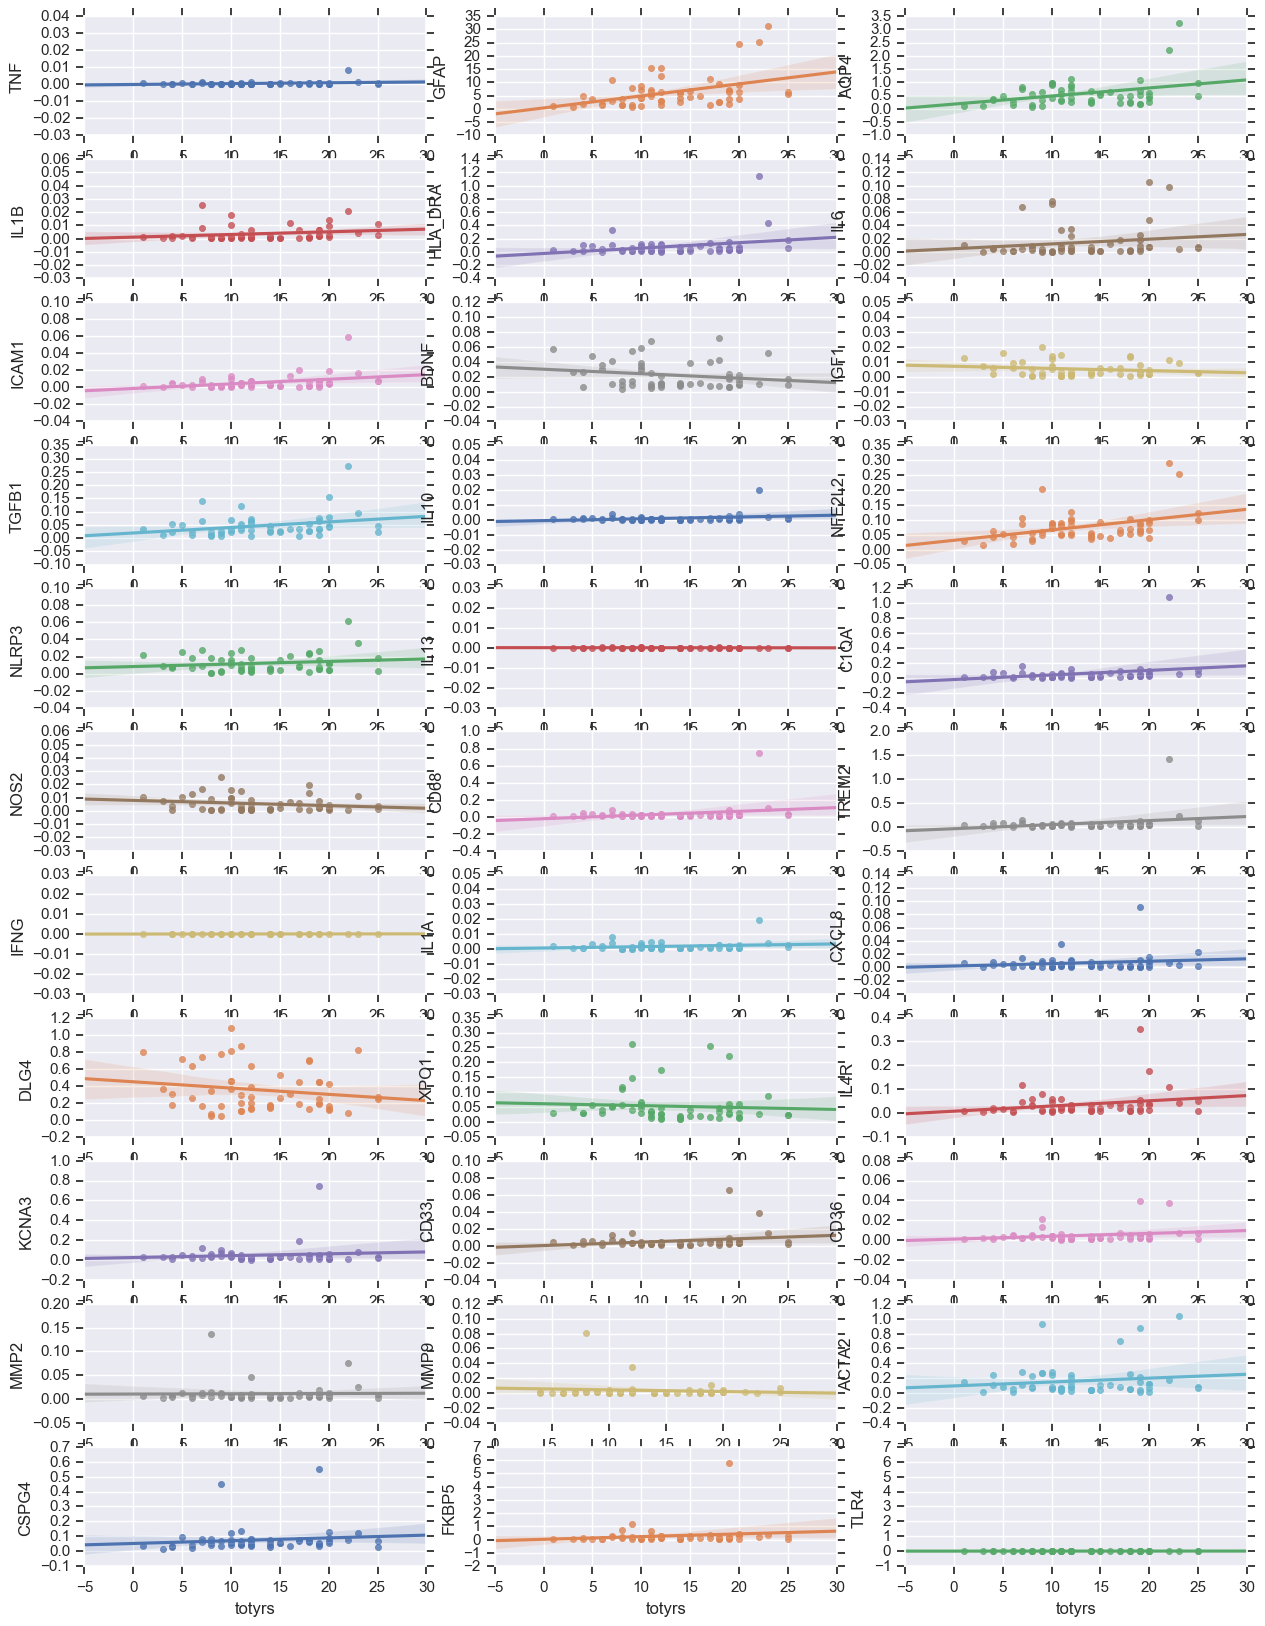

In [7]:
f, axs = plt.subplots(11,3, figsize=(15,20))
axs = axs.flatten()
for ax, i in zip(axs, range(len(qpcr_genes))):
    gene = qpcr_genes[i]
    sns.regplot(x='totyrs', y=gene, data=cnt_ty, ax=ax)   
#plt.savefig('qPCR_Log10_totyrs.png', bbox_inches='tight')

In [9]:
outliers = cnt_ty[(cnt_ty['HLA_DRA']>1)|(cnt_ty['C1QA']>1)|(cnt_ty['CD68']>0.6)|
                  (cnt_ty['KCNA3']>0.6)|(cnt_ty['TREM2']>1)|(cnt_ty['CSPG4']>0.4)|
                   (cnt_ty['FKBP5']>5)]

In [10]:
outliers['SampleName']

8     K_0084
48    K_0204
53    K_0148
Name: SampleName, dtype: object

In [84]:
# ALL, remove outliers
cnt_ty_no = cnt_ty[~cnt_ty['SampleName'].isin(outliers['SampleName'])]
ct_rhi = cnt_ty_no[cnt_ty_no['Diagnosis']!='CTES']
ctes = cnt_ty_no[cnt_ty_no['Diagnosis']=='CTES']
infoco = infoc[~infoc['SampleName'].isin(outliers['SampleName'])]
inter = cnt_ty_no[cnt_ty_no['SampleName'].isin(inter_id)]
print(len(outliers),len(cnt_ty),len(cnt_ty_no),len(infoco),len(ct_rhi),len(ctes),len(inter))

print('mRNASeq CTES/CTEM/RHIN: ',len(infoco[infoco['Diagnosis']=='CTES']),len(infoco[infoco['Diagnosis']=='CTEM']),len(infoco[infoco['Diagnosis']=='RHI']))
print('Inter CTES/CTEM/RHIN: ',len(cnt_ty_no[cnt_ty_no['Diagnosis']=='CTES']),len(cnt_ty_no[cnt_ty_no['Diagnosis']=='CTEM']),len(cnt_ty_no[cnt_ty_no['Diagnosis']=='RHI']))

pd.DataFrame({'Samples':['mRNAseq','qPCR/mRNASeq intersection'],'CTES':[48,35],
              'CTEM':[13,11],'RHIN':[7,7],'Total':[68,53]}, 
             columns=['Samples','CTES','CTEM','RHIN','Total'])

3 56 53 68 18 35 53
mRNASeq CTES/CTEM/RHIN:  48 13 7
Inter CTES/CTEM/RHIN:  35 11 7


Samples  CTES  CTEM  RHIN  Total
0                    mRNAseq    48    13     7     68
1  qPCR/mRNASeq intersection    35    11     7     53

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


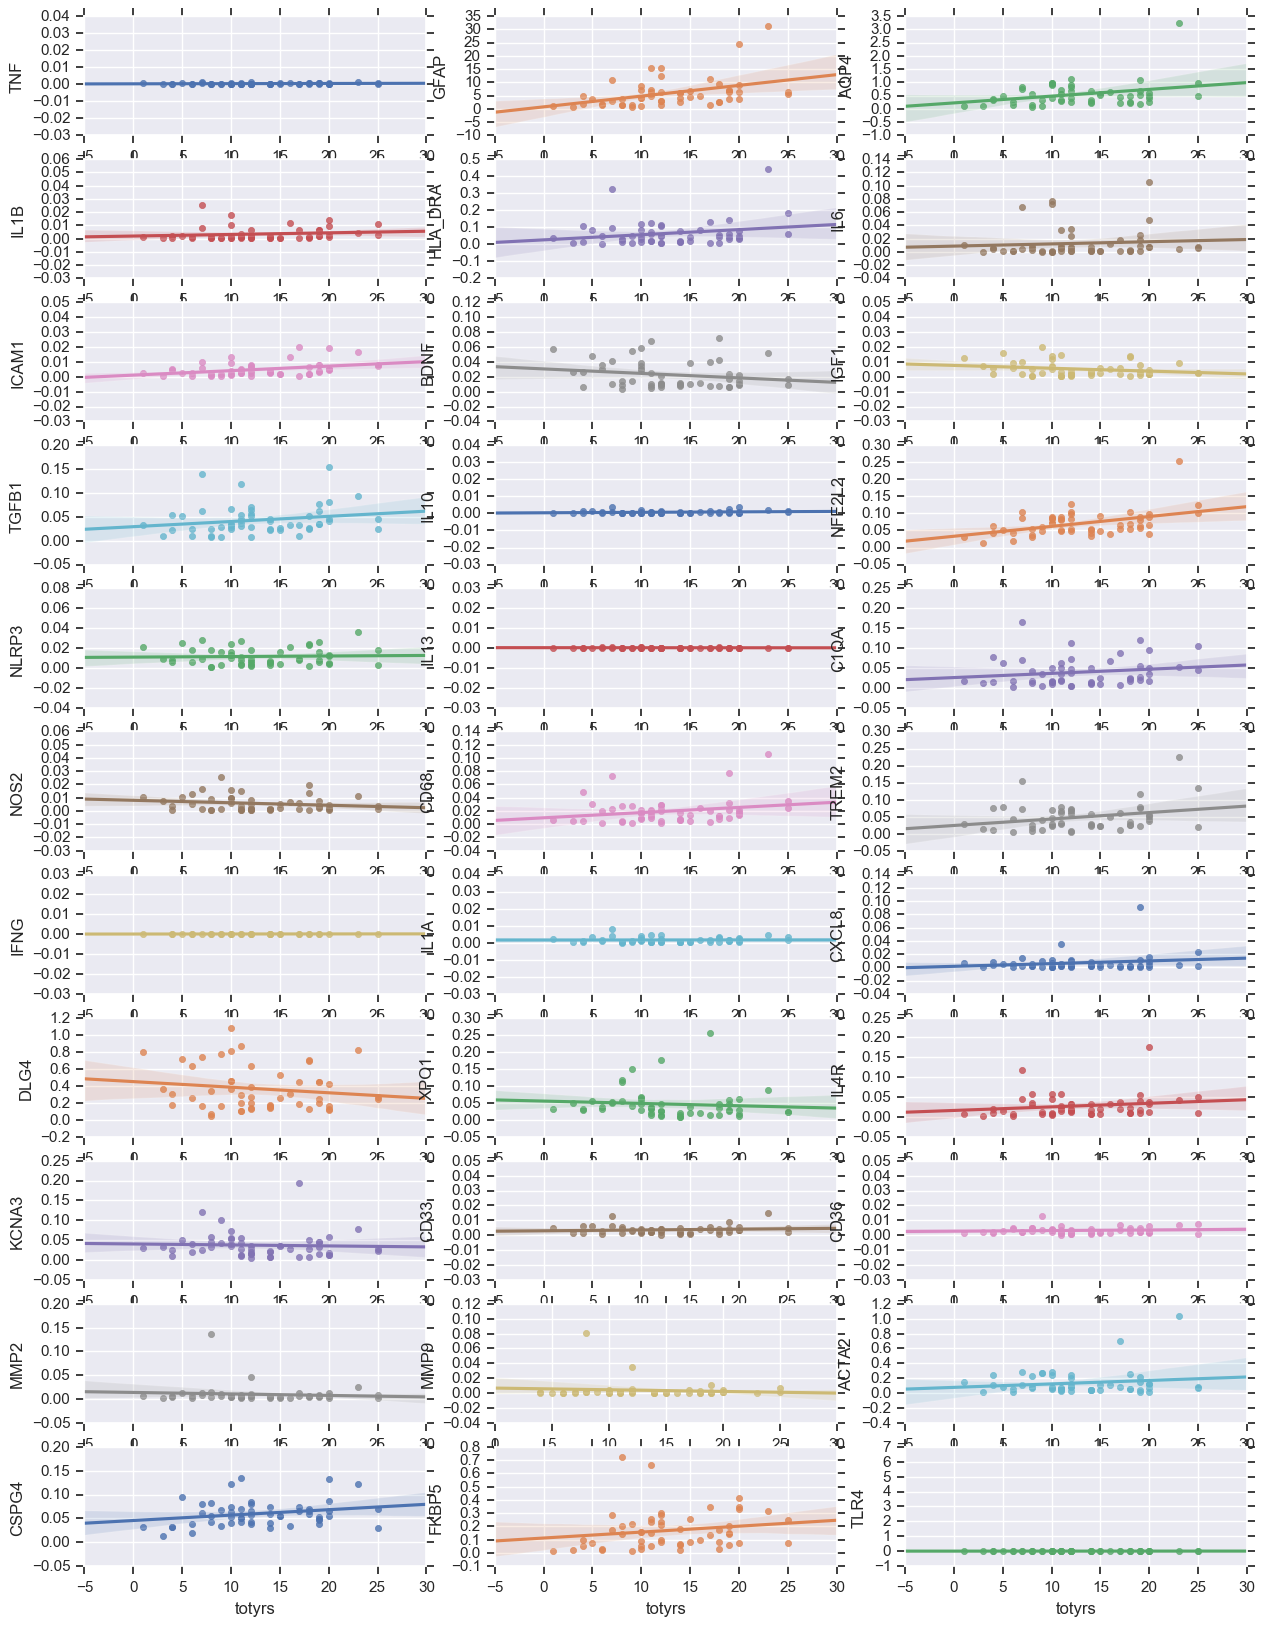

In [85]:
f, axs = plt.subplots(11,3, figsize=(15,20))
axs = axs.flatten()
for ax, i in zip(axs, range(len(qpcr_genes))):
    gene = qpcr_genes[i]
    sns.regplot(x='totyrs', y=gene, data=cnt_ty_no, ax=ax)   
#plt.savefig('qPCR_Log10_totyrs_removeoutliers.png', bbox_inches='tight')

### Linear Reg RNAseq

In [104]:
# Intersect RNAseq
inct_rhi = cnt_ty_no[cnt_ty_no['Diagnosis']!='CTES']
inctes = cnt_ty_no[cnt_ty_no['Diagnosis']=='CTES']

print('CTEM/RHIN: ',len(ct_rhi),'\t CTES: ',len(ctes),'\t CTEM/RHIN inter: ',len(inct_rhi),'\t CTES inter: ',len(inctes))

def LR(cov,df):
    res_all = pd.DataFrame()
    for gene in qpcr_genes:
        eqt = ' ~ ' + cov
        results = smf.ols(gene+eqt, data=df[[gene]+['RIN','age','totyrs']]).fit()
#    results = smf.ols(gene+' ~ RIN + age + AT8_crest', data=inctes[[gene]+['RIN','age','AT8_crest']]).fit()
#        print(gene,results.params,results.tvalues,results.pvalues)
        res_df = pd.DataFrame(pd.concat([results.params,results.tvalues,results.pvalues],axis=0)).T
        if cov != 'totyrs':
            res_df.columns = ['Intercept_L2FC','RIN_L2FC','age_L2FC','totyrs_L2FC',
                              'Intercept_tval','RIN_tval','age_tval','totyrs_tval',
                              'Intercept_pval','RIN_pval','age_pval','totyrs_pval']
        if cov == 'totyrs':
            res_df.columns = ['Intercept_L2FC', 'totyrs_L2FC','Intercept_tval','totyrs_tval','Intercept_pval','totyrs_pval']
        res_df['rsquared'] = results.rsquared
        res_df['gene'] = gene
        res_df = res_df[list(res_df)[-1:]+list(res_df)[:-1]]
        res_all = pd.concat([res_all,res_df],axis=0)
    res_all = res_all.reset_index(drop=True)
    if gene == 'CCL2':
        print(results.summary())
    return res_all
#res_all.to_csv('qPCR_CTEM_RHIN_inter_AT8_Lreg.csv', index=False)

CTEM/RHIN:  18 	 CTES:  35 	 CTEM/RHIN inter:  18 	 CTES inter:  35


In [105]:
LR_RAT_inter = [LR('RIN + age + totyrs', inct_rhi),LR('RIN + age + totyrs',inctes)]
LR_toty_inter = [LR('totyrs',inct_rhi),LR('totyrs',inctes)]

LR_all = LR_RAT_inter + LR_toty_inter
renames = []

for b in ['CTEM_RHIN_','CTES_']:
    renames += ['qpcr_RAT_'+b]
for b in ['CTEM_RHIN_','CTES_']:
    renames += ['qpcr_toty_'+b]

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                   CCL2   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.7640
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.533
Time:                        04:57:04   Log-Likelihood:                 52.232
No. Observations:                  18   AIC:                            -96.46
Df Residuals:                      14   BIC:                            -92.90
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0339      0.030     -1.148      0.2

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                   CCL2   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                   0.03881
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.846
Time:                        04:57:05   Log-Likelihood:                 50.889
No. Observations:                  18   AIC:                            -97.78
Df Residuals:                      16   BIC:                            -96.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0074      0.008      0.878      0.3

In [106]:
df = LR_all[0]
df.columns = list(df)[:1] + [renames[0]+_ for _ in list(df)[1:]]

for i in range(len(LR_all)-1):
    ndf = LR_all[i+1]
    ndf.columns = list(ndf)[:1] + [renames[i+1]+_ for _ in list(ndf)[1:]]
    df = pd.merge(df,ndf, on='gene')

In [107]:
df.columns

Index(['gene', 'qpcr_RAT_CTEM_RHIN_Intercept_L2FC',
       'qpcr_RAT_CTEM_RHIN_RIN_L2FC', 'qpcr_RAT_CTEM_RHIN_age_L2FC',
       'qpcr_RAT_CTEM_RHIN_totyrs_L2FC', 'qpcr_RAT_CTEM_RHIN_Intercept_tval',
       'qpcr_RAT_CTEM_RHIN_RIN_tval', 'qpcr_RAT_CTEM_RHIN_age_tval',
       'qpcr_RAT_CTEM_RHIN_totyrs_tval', 'qpcr_RAT_CTEM_RHIN_Intercept_pval',
       'qpcr_RAT_CTEM_RHIN_RIN_pval', 'qpcr_RAT_CTEM_RHIN_age_pval',
       'qpcr_RAT_CTEM_RHIN_totyrs_pval', 'qpcr_RAT_CTEM_RHIN_rsquared',
       'qpcr_RAT_CTES_Intercept_L2FC', 'qpcr_RAT_CTES_RIN_L2FC',
       'qpcr_RAT_CTES_age_L2FC', 'qpcr_RAT_CTES_totyrs_L2FC',
       'qpcr_RAT_CTES_Intercept_tval', 'qpcr_RAT_CTES_RIN_tval',
       'qpcr_RAT_CTES_age_tval', 'qpcr_RAT_CTES_totyrs_tval',
       'qpcr_RAT_CTES_Intercept_pval', 'qpcr_RAT_CTES_RIN_pval',
       'qpcr_RAT_CTES_age_pval', 'qpcr_RAT_CTES_totyrs_pval',
       'qpcr_RAT_CTES_rsquared', 'qpcr_toty_CTEM_RHIN_Intercept_L2FC',
       'qpcr_toty_CTEM_RHIN_totyrs_L2FC', 'qpcr_toty_CTEM_RHI

In [90]:
#df.to_csv('qpcr_ALL_linear_reg_totyrs.csv',index=False)

In [121]:
df

Gene name  qpcr_RAT_CTEM_RHIN_totyrs_L2FC  qpcr_RAT_CTEM_RHIN_totyrs_pval  \
0        TNF                   -8.248262e-06                        0.739883   
1       GFAP                    1.273491e-01                        0.145858   
2       AQP4                    1.749157e-02                        0.348374   
3       IL1B                   -6.025299e-05                        0.878714   
4    HLA_DRA                   -1.463823e-04                        0.974604   
5        IL6                   -5.124028e-04                        0.717489   
6      ICAM1                   -5.120550e-05                        0.819898   
7       BDNF                   -6.428947e-04                        0.448379   
8       IGF1                   -3.564501e-05                        0.852918   
9      TGFB1                    2.489193e-05                        0.989665   
10      IL10                   -1.740854e-05                        0.739954   
11    NFE2L2                    4.253501e-03                        0.004880   
12     NLRP3                    6.426871e-05                        0.879996   
13      IL13                   -1.593063e-06                        0.769524   
14      C1QA                   -2.495343e-04                        0.916033   
15      NOS2                    4.749108e-05                        0.846828   
16      CD68                   -8.128442e-05                        0.935520   
17     TREM2                    1.818787e-04                        0.932960   
18      IFNG                   -4.283958e-07                        0.923232   
19      IL1A                    3.285875e-05                        0.783774   
20     CXCL8                   -2.466369e-04                        0.324891   
21      DLG4                    7.353338e-04                        0.939112   
22      XPO1                    7.765706e-04                        0.753665   
23      IL4R                   -2.748095e-04                        0.877009   
24     KCNA3                    1.977729e-04                        0.908589   
25      CD33                    6.674774e-06                        0.967222   
26      CD36                    5.984756e-05                        0.717020   
27      MMP2                    3.221624e-04                        0.603887   
28      MMP9                    4.187447e-04                        0.446413   
29     ACTA2                   -1.021160e-03                        0.878017   
30     CSPG4                    1.977982e-03                        0.109014   
31     FKBP5                    3.455654e-03                        0.483499   
32      TLR4                    1.088036e-04                        0.565445   
33      CCL2                   -9.610711e-05                        0.916708   

    qpcr_RAT_CTES_totyrs_L2FC  qpcr_RAT_CTES_totyrs_pval  \
0                1.438624e-05                   0.190483   
1                3.294028e-01                   0.161500   
2                1.668369e-02                   0.400002   
3                1.889793e-04                   0.272442   
4                4.279723e-03                   0.150756   
5                9.999722e-04                   0.237855   
6                3.584594e-04                   0.049967   
7                1.894271e-04                   0.741618   
8                6.466530e-05                   0.536330   
9                1.529061e-03                   0.175874   
10               5.407151e-05                   0.104513   
11               2.049514e-03                   0.167442   
12               4.395283e-04                   0.117684   
13               5.480914e-07                   0.780665   
14               1.676161e-03                   0.180236   
15               7.593414e-05                   0.545855   
16               1.184952e-03                   0.130749   
17               2.414262e-03                   0.131262   
18               8.190784e-06                   0.062363   
19

## Compare L2FC

In [3]:
totyrs_DE = pd.read_csv('all_DE_totyrs_combined_annot.csv',sep=',')
keeps = [_ for _ in list(totyrs_DE) if "CTEM_RHIN" in _ or "CTE_34" in _]
keeps = list(totyrs_DE)[:2]+[_ for _ in keeps if "lfcSE" not in _ and "stat" not in _]
totyrs_DE["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
totyrs_DE = totyrs_DE[totyrs_DE['Gene name'].isin(qpcr_genes)][keeps]
print('Genes not in mRNASeq set: ',set(qpcr_genes).difference(set(totyrs_DE['Gene name'])))

df.columns = ['Gene name'] + list(df)[1:]
df_keep = list(df)[:1] +[_ for _ in list(df) if 'totyrs_L2FC' in _ or 'totyrs_pval' in _ ]
df = df[df_keep]

NameError: name 'qpcr_genes' is not defined

In [161]:
merged = pd.merge(totyrs_DE, df, on='Gene name')
merged.columns

Index(['Gene name', 'Name', 'CTE_34_NOtot_DE_totyrs_baseMean',
       'CTE_34_NOtot_DE_totyrs_L2FC', 'CTE_34_NOtot_DE_totyrs_pvalue',
       'CTE_34_NOtot_DE_totyrs_padj', 'CTEM_RHIN_NOtot_DE_totyrs_baseMean',
       'CTEM_RHIN_NOtot_DE_totyrs_L2FC', 'CTEM_RHIN_NOtot_DE_totyrs_pvalue',
       'CTEM_RHIN_NOtot_DE_totyrs_padj', 'qpcr_RAT_CTEM_RHIN_totyrs_L2FC',
       'qpcr_RAT_CTEM_RHIN_totyrs_pval', 'qpcr_RAT_CTES_totyrs_L2FC',
       'qpcr_RAT_CTES_totyrs_pval', 'qpcr_toty_CTEM_RHIN_totyrs_L2FC',
       'qpcr_toty_CTEM_RHIN_totyrs_pval', 'qpcr_toty_CTES_totyrs_L2FC',
       'qpcr_toty_CTES_totyrs_pval'],
      dtype='object')

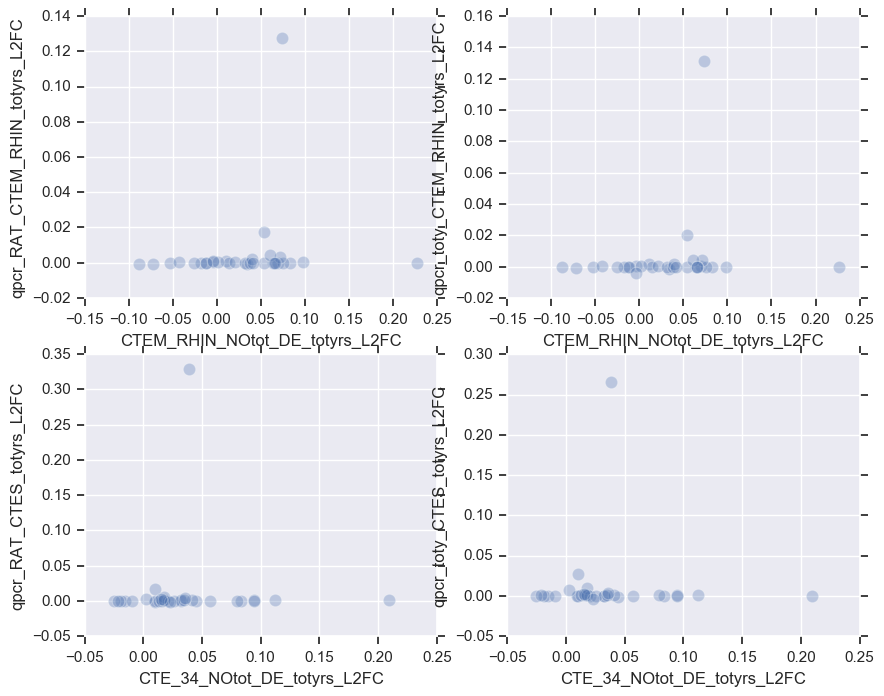

In [100]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(merged['CTEM_RHIN_NOtot_DE_totyrs_L2FC'],merged['qpcr_RAT_CTEM_RHIN_totyrs_L2FC'], alpha=0.3, s=80)
plt.subplot(2, 2, 2)
sns.scatterplot(merged['CTEM_RHIN_NOtot_DE_totyrs_L2FC'],merged['qpcr_toty_CTEM_RHIN_totyrs_L2FC'], alpha=0.3, s=80)
plt.subplot(2, 2, 3)
sns.scatterplot(merged['CTE_34_NOtot_DE_totyrs_L2FC'],merged['qpcr_RAT_CTES_totyrs_L2FC'], alpha=0.3, s=80)
plt.subplot(2, 2, 4)
sns.scatterplot(merged['CTE_34_NOtot_DE_totyrs_L2FC'],merged['qpcr_toty_CTES_totyrs_L2FC'], alpha=0.3, s=80)

### Spearman correlation

In [101]:
print(spearmanr(merged['CTEM_RHIN_NOtot_DE_totyrs_L2FC'],merged['qpcr_RAT_CTEM_RHIN_totyrs_L2FC']))
print(spearmanr(merged['CTE_34_NOtot_DE_totyrs_L2FC'],merged['qpcr_RAT_CTES_totyrs_L2FC']))

print(spearmanr(merged['CTEM_RHIN_NOtot_DE_totyrs_L2FC'],merged['qpcr_toty_CTEM_RHIN_totyrs_L2FC']))
print(spearmanr(merged['CTE_34_NOtot_DE_totyrs_L2FC'],merged['qpcr_toty_CTES_totyrs_L2FC']))

SpearmanrResult(correlation=0.06818181818181818, pvalue=0.7108003843260133)
SpearmanrResult(correlation=0.19098240469208208, pvalue=0.2950752057172716)
SpearmanrResult(correlation=0.15175953079178883, pvalue=0.4070226940104208)
SpearmanrResult(correlation=0.03409090909090909, pvalue=0.8530499667748352)


### Size points

In [110]:
sp = merged[['Gene name', 'Name', 'CTEM_RHIN_NOtot_DE_totyrs_L2FC','CTEM_RHIN_NOtot_DE_totyrs_padj',
            'CTE_34_NOtot_DE_totyrs_L2FC','CTE_34_NOtot_DE_totyrs_padj',
            'qpcr_RAT_CTEM_RHIN_totyrs_L2FC','qpcr_RAT_CTES_totyrs_L2FC',
            'qpcr_toty_CTEM_RHIN_totyrs_L2FC','qpcr_toty_CTES_totyrs_L2FC',
            'qpcr_RAT_CTEM_RHIN_totyrs_pval','qpcr_RAT_CTES_totyrs_pval',
            'qpcr_toty_CTEM_RHIN_totyrs_pval','qpcr_toty_CTES_totyrs_pval']]
sp['CTE_34_NOtot_DE_totyrs_padj'] = -np.log10(sp['CTE_34_NOtot_DE_totyrs_padj'])
sp['CTEM_RHIN_NOtot_DE_totyrs_padj'] = -np.log10(sp['CTEM_RHIN_NOtot_DE_totyrs_padj'])

/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


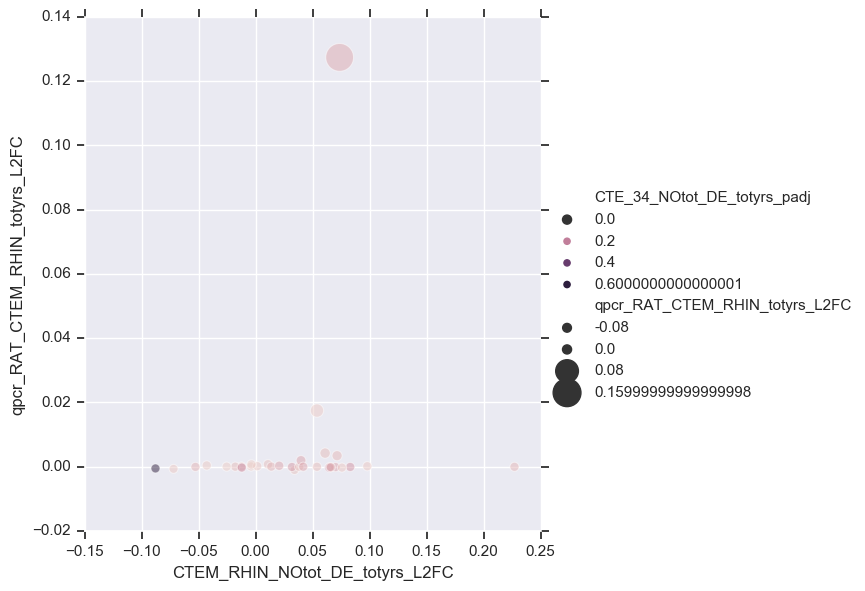

In [111]:
#fig, ax = plt.subplots(figsize=(10, 10))
#plt.subplot(2, 2, 1)
sns.relplot(x='CTEM_RHIN_NOtot_DE_totyrs_L2FC', y='qpcr_RAT_CTEM_RHIN_totyrs_L2FC', 
            hue='CTE_34_NOtot_DE_totyrs_padj', 
            size='qpcr_RAT_CTEM_RHIN_totyrs_L2FC',
            sizes=(40, 400), alpha=.5,height=6, data=sp)
#plt.ylim(-0.0004,0.001)

In [163]:
sp = merged[['Gene name', 'Name', 'CTEM_RHIN_NOtot_DE_totyrs_L2FC','CTEM_RHIN_NOtot_DE_totyrs_padj',
            'CTE_34_NOtot_DE_totyrs_L2FC','CTE_34_NOtot_DE_totyrs_padj',
            'qpcr_RAT_CTES_totyrs_L2FC','qpcr_RAT_CTES_totyrs_L2FC',
            'qpcr_toty_CTEM_RHIN_totyrs_L2FC','qpcr_toty_CTES_totyrs_L2FC',
            'qpcr_RAT_CTEM_RHIN_totyrs_pval','qpcr_RAT_CTES_totyrs_pval',
            'qpcr_toty_CTEM_RHIN_totyrs_pval','qpcr_toty_CTES_totyrs_pval']]

### Confusion Matrix

In [164]:
eq = 'qpcr_toty'
cm_ctem = pd.DataFrame({'qpcr':['Up','Down'], 
             'DE_UP':[len(sp[(sp['CTEM_RHIN_NOtot_DE_totyrs_L2FC']>0) & (sp[eq+'_CTEM_RHIN_totyrs_L2FC']>0)]),
                     len(sp[(sp['CTEM_RHIN_NOtot_DE_totyrs_L2FC']>0) & (sp[eq+'_CTEM_RHIN_totyrs_L2FC']<0)])],
             'DE_Down':[len(sp[(sp['CTEM_RHIN_NOtot_DE_totyrs_L2FC']<0) & (sp[eq+'_CTEM_RHIN_totyrs_L2FC']>0)]),
                     len(sp[(sp['CTEM_RHIN_NOtot_DE_totyrs_L2FC']<0) & (sp[eq+'_CTEM_RHIN_totyrs_L2FC']<0)])]}, 
             columns=['qpcr','DE_UP','DE_Down'])

cm_ctes = pd.DataFrame({'qpcr':['Up','Down'], 
                        'DE_UP':[len(sp[(sp['CTE_34_NOtot_DE_totyrs_L2FC']>0) & (sp[eq+'_CTES_totyrs_L2FC']>0)]),
                                 len(sp[(sp['CTE_34_NOtot_DE_totyrs_L2FC']>0) & (sp[eq+'_CTES_totyrs_L2FC']<0)])],
                        'DE_Down':[len(sp[(sp['CTE_34_NOtot_DE_totyrs_L2FC']<0) & (sp[eq+'_CTES_totyrs_L2FC']>0)]),
                                   len(sp[(sp['CTE_34_NOtot_DE_totyrs_L2FC']<0) & (sp[eq+'_CTES_totyrs_L2FC']<0)])]}, 
             columns=['qpcr','DE_UP','DE_Down'])

In [165]:
print(cm_ctem, '\n',cm_ctes)

   qpcr  DE_UP  DE_Down
0    Up     10        4
1  Down     12        6 
    qpcr  DE_UP  DE_Down
0    Up     23        5
1  Down      4        0


In [166]:
cm_ctem

qpcr  DE_UP  DE_Down
0    Up     10        4
1  Down     12        6

In [167]:
cm_ctes

qpcr  DE_UP  DE_Down
0    Up     23        5
1  Down      4        0

In [168]:
p = 0.05
qctr_sig = sp[(sp['CTEM_RHIN_NOtot_DE_totyrs_padj'] < p) & (sp[eq+'_CTEM_RHIN_totyrs_pval'] < p)]
qcts_sig = sp[(sp['CTE_34_NOtot_DE_totyrs_padj'] < p) & (sp[eq+'_CTES_totyrs_pval'] < p)]
print(len(qctr_sig),len(qcts_sig))

pd.DataFrame({'qpcr':['Up','Down'], 
             'DE_UP':[len(qctr_sig[(qctr_sig['CTE_34_NOtot_DE_totyrs_L2FC']>0) & (qctr_sig[eq+'_CTES_totyrs_L2FC']>0)]),
                     len(qctr_sig[(qctr_sig['CTE_34_NOtot_DE_totyrs_L2FC']>0) & (qctr_sig[eq+'_CTES_totyrs_L2FC']<0)])],
             'DE_Down':[len(qctr_sig[(qctr_sig['CTE_34_NOtot_DE_totyrs_L2FC']<0) & (qctr_sig[eq+'_CTES_totyrs_L2FC']>0)]),
                     len(qctr_sig[(qctr_sig['CTE_34_NOtot_DE_totyrs_L2FC']<0) & (qctr_sig[eq+'_CTES_totyrs_L2FC']<0)])]}, 
             columns=['qpcr','DE_UP','DE_Down'])

0 0


qpcr  DE_UP  DE_Down
0    Up      0        0
1  Down      0        0

In [158]:
qctr_sig

Gene name             Name  CTEM_RHIN_NOtot_DE_totyrs_L2FC  \
27    NFE2L2  ENSG00000116044                        0.060972   

    CTEM_RHIN_NOtot_DE_totyrs_padj  CTE_34_NOtot_DE_totyrs_L2FC  \
27                        0.000127                     0.015393   

    CTE_34_NOtot_DE_totyrs_padj  qpcr_RAT_CTEM_RHIN_totyrs_L2FC  \
27                     0.050009                        0.004254   

    qpcr_RAT_CTES_totyrs_L2FC  qpcr_toty_CTEM_RHIN_totyrs_L2FC  \
27                    0.00205                          0.00421   

    qpcr_toty_CTES_totyrs_L2FC  qpcr_RAT_CTEM_RHIN_totyrs_pval  \
27                    0.002622                         0.00488   

    qpcr_RAT_CTES_totyrs_pval  qpcr_toty_CTEM_RHIN_totyrs_pval  \
27                   0.167442                         0.004274   

    qpcr_toty_CTES_totyrs_pval  
27                     0.04593

In [133]:
toty = pd.read_csv("all_DE_totyrs_combined_annot.csv", sep=",")
toty.columns = [_.replace('_NOtot_DE_totyrs','') for _ in list(toty)]
toty_genes = toty['Name'].head(n=20).tolist()
toty["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
toty['cat'] = pd.Categorical(deat8['Gene name'], categories=qpcr_genes, ordered=True)
cols = ['Gene name','CTEM_RHIN_baseMean','CTEM_RHIN_L2FC','CTEM_RHIN_pvalue','CTEM_RHIN_padj',
        'CTE_34_baseMean','CTE_34_L2FC','CTE_34_pvalue','CTE_34_padj','cat']
toty = toty[cols]
toty.columns = ['Gene name','CTEM_RHIN_BM','CTEM_RHIN_L2FC','CTEM_RHIN_pvalue','CTEM_RHIN_padj',
                 'CTE_34_BM','CTE_34_L2FC','CTE_34_pvalue','CTE_34_padj','cat']

In [134]:
d = toty[(toty['Gene name'].isin(qpcr_genes)) & (toty['Gene name']!='HLA_DRA')].sort_values('cat')

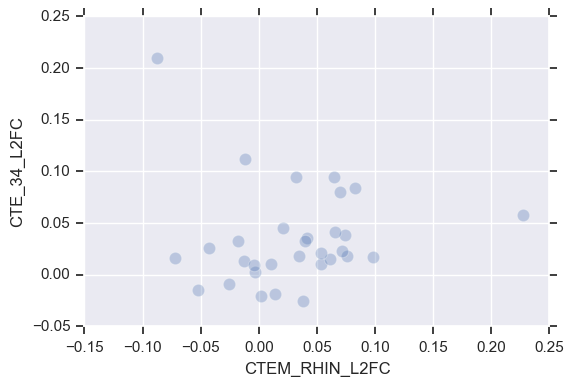

In [135]:
#sigdeat8 = deat8[(deat8['CTEM_RHIN_pvalue']<0.05)&(deat8['CTE_34_pvalue']<0.05)]
sns.scatterplot(d['CTEM_RHIN_L2FC'],d['CTE_34_L2FC'], alpha=0.3, s=80)

In [148]:
infom = pd.read_csv('../CTE_sample_info_all.csv', sep=',')
infom = infom[infom['Status']!= 'CNT']
infom['SampleName']=['{}-{:03d}'.format(_.split('-')[0], int(_.split('-')[1])) if 'SLI' in _ else _ for _ in infom['SampleName']]
infom['SampleName'] = [_.replace('-','_') for _ in infom['SampleName'].tolist()]
all_cnts = pd.read_csv('../all_wocnt_all_counts_filt_norm.csv', sep=',')
all_cnts.loc[:, ['Name']] = all_cnts['Name'].str.split('.').str[0]
ensembl = pd.read_csv("../biomart_export_grch38p12.txt", sep='\t', usecols=[0,1])
ensembl.columns = ['Name', 'Gene name']
infom = infom[infom['SampleName'].isin(inter_id)]
infom = infom[~infom['SampleName'].isin(outliers['SampleName'].tolist())]

infom = infom.set_index(['ID'])
infom = infom.sort_values('totyrs')
ordered = list(infom.index)
print(len(infom))
infom.head()

plot_hm = pd.merge(ensembl, all_cnts, on='Name')
plot_hm["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
plot_hm = plot_hm[list(plot_hm)[1:]]
plot_hm = plot_hm.set_index('Gene name')
plot_hm = plot_hm[ordered]
plot_hm = plot_hm.T
plot_hm['Status'] = plot_hm.index.str.split('_').str[0]

sub_type = plot_hm.pop('Status')
lut = dict(zip(sub_type.unique(), ["green","purple","yellow"]))
#lut = dict(zip(sub_type.unique(), ["green","yellow"]))
col_colors = sub_type.map(lut)
plot_hm = plot_hm.T
print(len(infom))
print(lut)

53
53
{'CTEM': 'green', 'CTES': 'purple', 'RHIN': 'yellow'}


/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


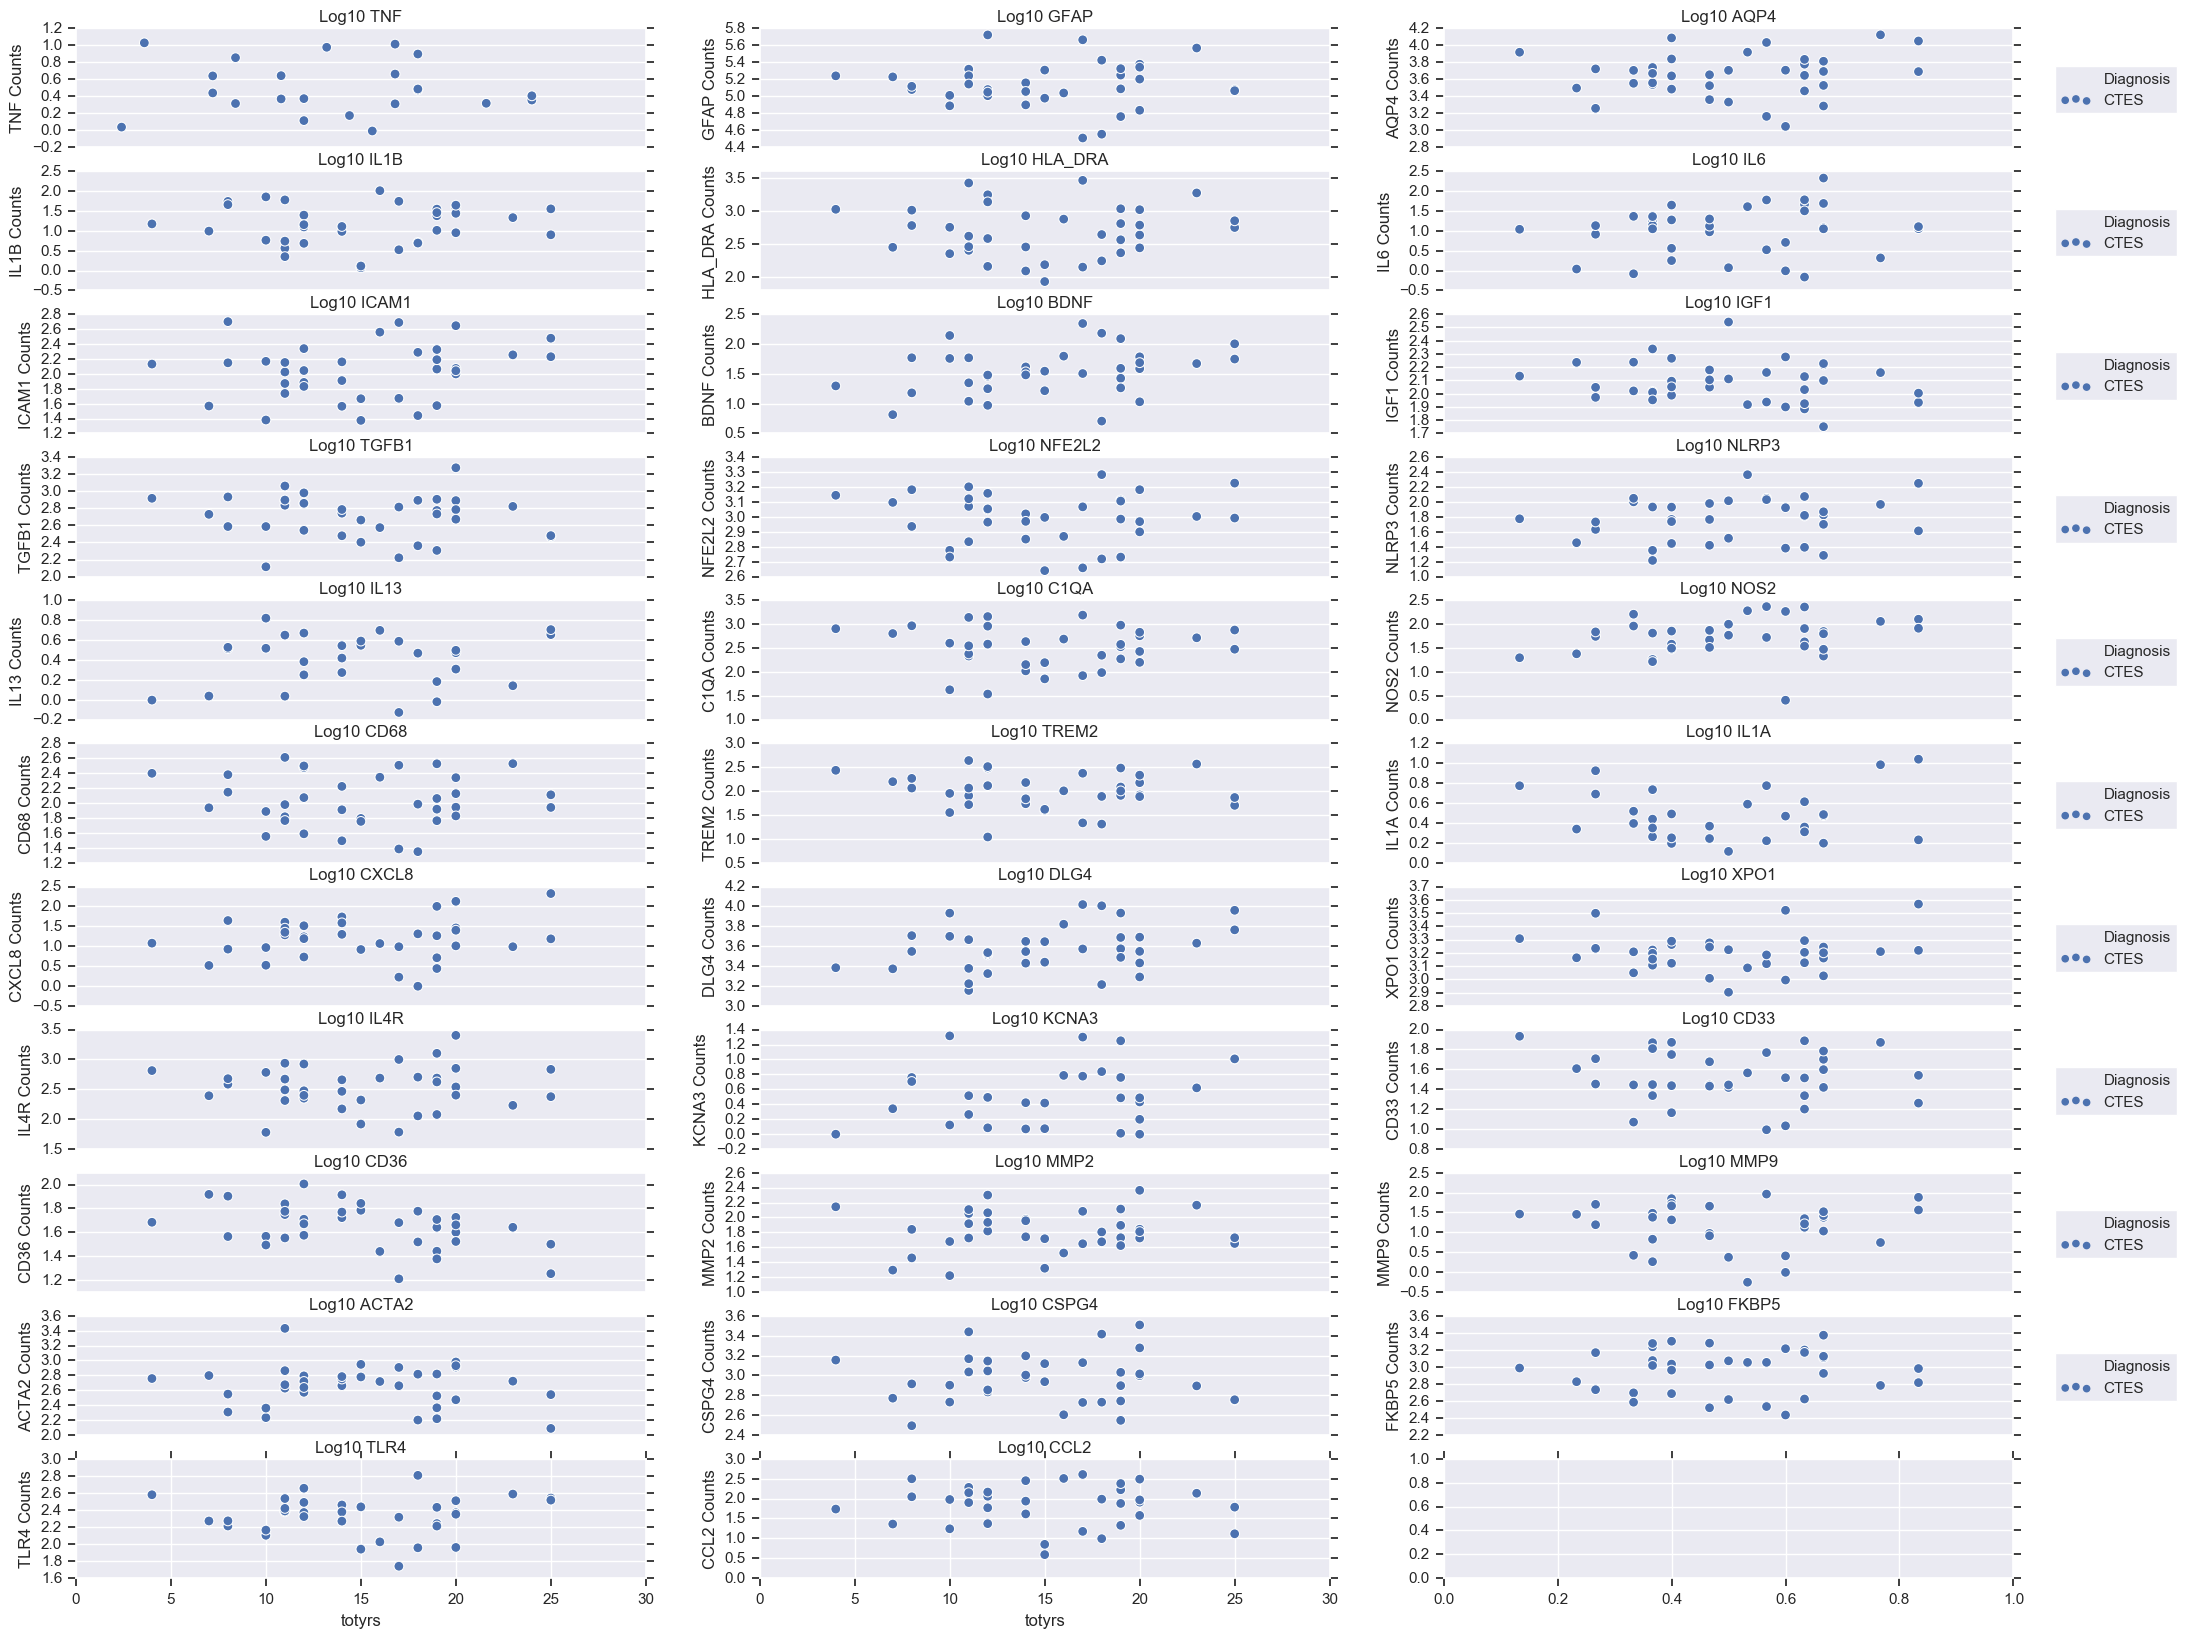

In [151]:
# reminder: toty = [ctes_ty, cmrhi_ty]
f,axs = plt.subplots(11,3, figsize=(25,20))
axs = it.chain(*[list(_) for _ in axs])

genes = [ _ for _ in qpcr_genes if 'IL10' not in _ and 'IFNG' not in _]

for i, (gene,ax) in enumerate(zip(genes, axs)):
    a = pd.merge(plot_hm.T[[gene]], infom[['totyrs','Diagnosis']], left_index=True, right_index=True)
    a[gene] = np.log10(a[gene])
    a = a.replace(-np.Inf, np.nan)
    a = a[['CTES' in s for s in a.index]]
    sns.scatterplot(x='totyrs', y=gene, data=a, hue='Diagnosis', s=50, ax=ax)
    ax.set_ylabel(gene + ' Counts')
    ax.set_title('Log10 ' + gene, fontsize=12)
    ax.legend(bbox_to_anchor=(1.3, 0.75))
    if i < 30:
        ax.get_xaxis().set_visible(False)
    if i not in [2,5,8,11,14,17,20,23,26,29,32]:
        ax.legend().set_visible(False)
#next(axs).axis('off')
plt.savefig('qpcr_matching_CS_totyrs.png', bbox_inches='tight')

In [20]:
totyrs_DE = pd.read_csv('all_DE_totyrs_combined_annot.csv',sep=',')
totyrs_DE = totyrs_DE[~totyrs_DE['CTE_34_NOtot_DE_totyrs_L2FC'].isnull()]
totyrs_DE = totyrs_DE[~totyrs_DE['CTEM_RHIN_NOtot_DE_totyrs_L2FC'].isnull()]

In [21]:
totyrs_DE.columns

Index(['Gene name', 'Name', 'CTE_34_NOtot_DE_totyrs_baseMean',
       'CTE_34_NOtot_DE_totyrs_L2FC', 'CTE_34_NOtot_DE_totyrs_lfcSE',
       'CTE_34_NOtot_DE_totyrs_stat', 'CTE_34_NOtot_DE_totyrs_pvalue',
       'CTE_34_NOtot_DE_totyrs_padj', 'CTES_CTEM_NOtot_DE_totyrs_baseMean',
       'CTES_CTEM_NOtot_DE_totyrs_L2FC', 'CTES_CTEM_NOtot_DE_totyrs_lfcSE',
       'CTES_CTEM_NOtot_DE_totyrs_stat', 'CTES_CTEM_NOtot_DE_totyrs_pvalue',
       'CTES_CTEM_NOtot_DE_totyrs_padj', 'all_wocnt_NOtot_DE_totyrs_baseMean',
       'all_wocnt_NOtot_DE_totyrs_L2FC', 'all_wocnt_NOtot_DE_totyrs_lfcSE',
       'all_wocnt_NOtot_DE_totyrs_stat', 'all_wocnt_NOtot_DE_totyrs_pvalue',
       'all_wocnt_NOtot_DE_totyrs_padj',
       'all_RHIN_NOtot_DE_totyrs_status_baseMean',
       'all_RHIN_NOtot_DE_totyrs_status_L2FC',
       'all_RHIN_NOtot_DE_totyrs_status_lfcSE',
       'all_RHIN_NOtot_DE_totyrs_status_stat',
       'all_RHIN_NOtot_DE_totyrs_status_pvalue',
       'all_RHIN_NOtot_DE_totyrs_status_padj',
     

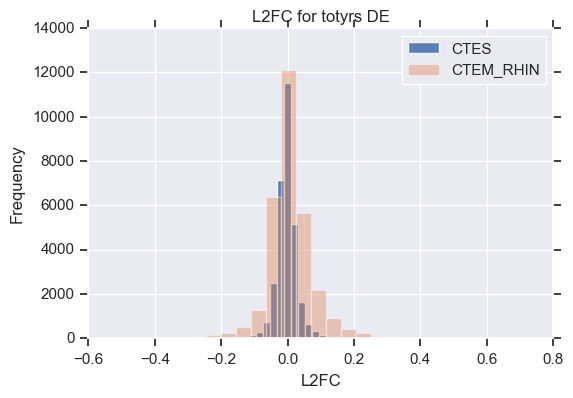

In [38]:
b = 30
plt.hist(totyrs_DE['CTE_34_NOtot_DE_totyrs_L2FC'],alpha=0.9, label='CTES', bins=b)
plt.hist(totyrs_DE['CTEM_RHIN_NOtot_DE_totyrs_L2FC'],alpha=0.4, label='CTEM_RHIN',bins=b)
plt.legend(loc='upper right')
plt.xlabel('L2FC')
plt.ylabel('Frequency')
plt.title('L2FC for totyrs DE')

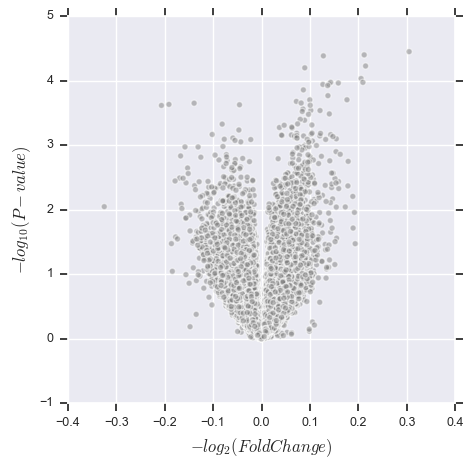

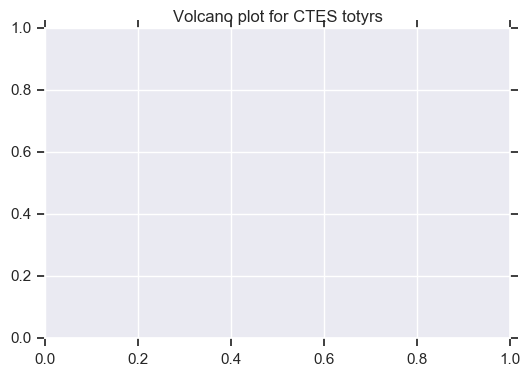

In [55]:
from bioinfokit import visuz

visuz.gene_exp.volcano(totyrs_DE, lfc='CTE_34_NOtot_DE_totyrs_L2FC', pv='CTE_34_NOtot_DE_totyrs_pvalue',
                       show=True,valpha=0.5,dotsize=20)

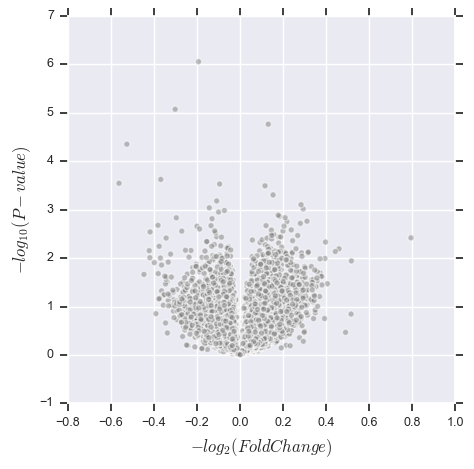

In [54]:
visuz.gene_exp.volcano(totyrs_DE, lfc='CTEM_RHIN_NOtot_DE_totyrs_L2FC', pv='CTEM_RHIN_NOtot_DE_totyrs_pvalue',
                       show=True,valpha=0.5,dotsize=20)